<p style="text-align: center;"><span style="color: #ff0000;"><strong><span style="font-size: x-large;">
    ANEXO XXX: USO DE LA LIBRERIA LATTPY</span></strong></span></p>

<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Realizado por:</span></strong></span></p>
<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Gabriel Vacaro Goytia</span></strong></span></p>
<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Ignacio Warleta Murcia</span></strong></span></p>

En este anexo, profundizaremos en el concepto de retículo, abordando tanto su definición teórica como un ejemplo de implementación práctica utilizando la librería LattPy. Esta herramienta permite no solo visualizar y manipular retículos de manera eficiente, sino también explorar sus propiedades matemáticas, estructurales y geométricas en diversos contextos.

LattPy se destaca por su facilidad de uso y flexibilidad, lo que la convierte en una opción ideal tanto para principiantes que buscan comprender los fundamentos de los retículos, como para investigadores expertos. En este anexo, se presentarán ejemplos prácticos que ilustran cómo definir distintos tipos de retículos, modificar sus características y analizar propiedades como la periodicidad, las distancias entre nodos y las conexiones entre ellos.

Organizamos el anexo según el siguiente índice:

# Índice
1. [Introducción](#1.-Introducción)
2. [Configuración](#2.-Configuración)
3. [Implementación](#3.-Implementacion)
   - [Generar Retículos](#3.1-Generar-Reticulos)
   - [Generar Conexiones](#3.2-Generar-Conexiones)

---
# 1. Introducción

Como se ha explicado en el documento, un retículo (*lattice* o celosía), $L$, se trata de una estructura algebraica compuesta por un conjunto de puntos en un espacio, donde cada punto puede ser descrito como una combinación lineal de vectores base con coeficientes enteros. Estos puntos están organizados de manera regular y se extienden infinitamente en todas las direcciones, formando una red de puntos que se repite periódicamente.

Es decir, dada una base de vectores $B= \{b_1, \dots, b_m\}$, un retículo $L$ es un subespacio vectorial formado por las combinaciones lineales enteras de los elementos de la base $b_i$:

$$
L = \left\{ \sum_{i=1}^m a_i \cdot b_i : a_i \in \mathbb{Z} \right\} = \{ B \cdot a : a \in \mathbb{Z} \}.
$$

El conjunto $B = \{b_1, \dots, b_m\}$ se denomina base del retículo. El retículo generado por la base $B$ se denota por $L(B)$.



---

# 2. Configuración

Para comenzar a trabajar con LattPy, es necesario ejecutar la celda que aparece a continuación. Esta celda contiene los comandos necesarios para importar los módulos y bibliotecas requeridos por el código, asegurando así que todas las funcionalidades de este cuaderno estén disponibles y operen correctamente. 

In [1]:
#MODULOS A IMPORTAR
import numpy as np
import lattpy as lp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import time  # Importar time para medir el tiempo

A continuación, se definen algunas funciones personalizadas que utilizaremos a lo largo del documento:

- añadir únicos con coordenadas aleatorias
- Generar puntos de un retículo basado en una matriz base y un rango de enteros


In [3]:
#FUNCIONES UTILIZADAS

def add_atom(latt, num_atoms, dim):
    """
    Crea átomos en la red con posiciones aleatorias y únicas, esto se traducirá en nuevas capas por cada átomo añadido.
    
    Parámetros:
    - latt: reticulo donde se agregarán los átomos.
    - num_atoms: número de átomos a crear.
    - dim: número de dimensiones del espacio.

    Retorna:
    - None
    """
    # Crear un conjunto para asegurarnos de que las posiciones sean únicas
    generated_positions = set()

    #Mientras que haya menos posiciones que numero de atomos a crear:
    while len(generated_positions) < num_atoms:
        # Generar coordenadas aleatorias en [0, 1) para todas las dimensiones
        coords = tuple(np.random.rand(dim)) # Ejemplo con dim = 5: coords = [0.12 0.45 0.67 0.89 0.23]
        generated_positions.add(coords)  

    # Agregar átomos generados a al red
    for i, coords in enumerate(generated_positions):
        name = f"Atom_{i + 1}"  # Nombra los átomos de forma automática
        latt.add_atom(list(coords), name)

# Función para generar los puntos del retículo
def generate_lattice_points(base, limit):
    """
    Genera todos los puntos del retículo dados los vectores base y un límite 
    (es necesario acotar el retículo para que sea computacionalmente viable).

    Parámetros:
    - base: vectores iniciales que generan el retículo.
    - limit: rango de los valores enteros para las combinaciones.

    Retorna:
    - Array con todos los puntos del retículo.
    """
    # Generamos todas las combinaciones posibles de los enteros para [-limit,limit]
    combinations_k = list(product(range(-limit, limit + 1), repeat=base.shape[0])) # Ejemplo con base 1 dimensional y limite 1:
                                                                                   # [(-1,), (0,), (1,)]

    # Generamos los puntos del retículo como combinaciones lineales de los vectores base
    # Ejemplo: si k = (1, -1) y base = [[1, 0], [0, 1]], entonces point = [1, -1]
    lattice_points = []
    for k in combinations_k:
        point = sum(k[i] * base[i] for i in range(len(k)))
        lattice_points.append(point)
     
    return np.array(lattice_points)


---
# 3. Implementacion


### 3.1 Generar Reticulos

A continuación, generaremos algunos retículos simples, es decir, aquellos que estan comprendidos en dimensiones pequeñas. Para esto, necesitamos conocer cuáles son las propiedades básicas de un retículo:

- **num_atoms**: número de átomos que tendrá el retículo (explicado más adelante).
- **dim**: dimensión del retículo, se utilizará para crear una matriz identidad `dim × dim` para establecer los vectores base (gran impacto en el rendimiento).
- **limit**: tamaño máximo en cada eje dimensional para acotar el retículo, pues una implementación no puede albergar un retículo infinito.
- **num_conex**: número de conexiones a los `num_conex` vecinos más cercanos.

primeramente, generaremos un retículo unidimensional, con un solo átomo y un límite de coordenadas igual a cinco, cuyos puntos solo esten conectados a su vecino más cercano.


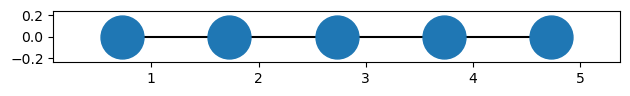

In [20]:
#VARIABLES
num_atoms = 1
dim = 1
limit = 5
num_conex = 1

base = np.eye(dim)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base) # Crear el retículo con lattpy
add_atom(latt, num_atoms, dim) # Añadir un solo atomo al retículo
latt.add_connections(num_conex)  # Conexión al vecino mas cercano
latt.build((limit,) * dim) # Construir un retículo finito de tamaño 5
latt.analyze() # Funcion necesaria para analizar y calcular propiedades estructurales del retículo
latt.plot() 
plt.show()

En esta representación, podemos observar que un **retículo** no es más que una serie de puntos conectados entre sí. En este caso, la **base del retículo** está formada por un único vector, equivalente a `1`, el cual genera los siguientes puntos:

$
P = \{ p_n \mid p_n = 1 \times n, \quad n \in \{0, 1, 2, 3, 4\} \}
$

O explícitamente:


P = \{ 0, 1, 2, 3, 4 \}


Nuevamente, generemos otro **retículo**, pero esta vez en **dos dimensiones**

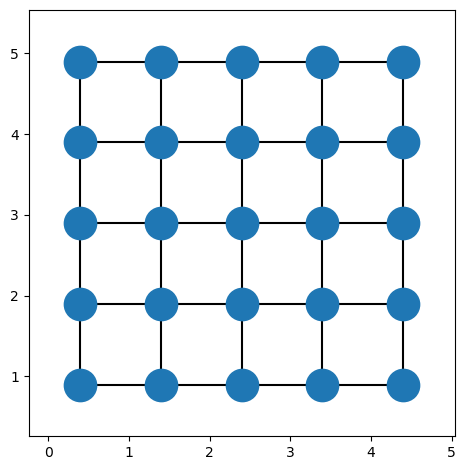

In [21]:
#VARIABLES
num_atoms = 1
dim = 2
limit = 5
num_conex = 1

base = np.eye(dim)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base) # Crear el retículo con lattpy
add_atom(latt, num_atoms, dim) # Añadir un solo atomo al retículo
latt.add_connections(num_conex)  # Conexión al vecino mas cercano
latt.build((limit,) * dim) # Construir un retículo finito de tamaño 5
latt.analyze() # Funcion necesaria para analizar y calcular propiedades estructurales del retículo
latt.plot() 
plt.show()

En esta representación, podemos observar que la **base del retículo** está formada por dos vectores, equivalentes a $[1,0]$ y $[0,1]$, los cuales generan los siguientes puntos:

$$
P = \{ p_{m,n} \mid p_{m,n} = m \cdot [1,0] + n \cdot [0,1], \quad m, n \in \{0, 1, 2, 3, 4\} \}
$$

O explícitamente:

$$
P = \{ (m, n) \mid m, n \in \{0, 1, 2, 3, 4\} \}
$$

Generaremos ahora por último un **retículo** en **tres dimensiones**:

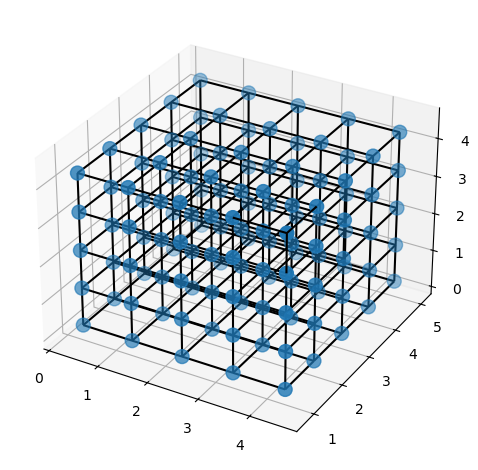

In [22]:
#VARIABLES
num_atoms = 1
dim = 3
limit = 5
num_conex = 1

base = np.eye(dim)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base) # Crear el retículo con lattpy
add_atom(latt, num_atoms, dim) # Añadir un solo atomo al retículo
latt.add_connections(num_conex)  # Conexión al vecino mas cercano
latt.build((limit,) * dim) # Construir un retículo finito de tamaño 5
latt.analyze() # Funcion necesaria para analizar y calcular propiedades estructurales del retículo
latt.plot() 
plt.show()

En esta representación, podemos observar que la **base del retículo** está formada por tres vectores, equivalentes a $[1,0,0]$, $[0,1,0]$ y $[0,0,1]$, los cuales generan los siguientes puntos:

$$
P = \{ p_{m,n,k} \mid p_{m,n,k} = m \cdot [1,0,0] + n \cdot [0,1,0] + k \cdot [0,0,1], \quad m, n, k \in \{0, 1, 2, 3, 4\} \}
$$

O explícitamente:

$$
P = \{ (m, n, k) \mid m, n, k \in \{0, 1, 2, 3, 4\} \}
$$

En general, como se comentó en la definición de retículo, los puntos generados serán las combinaciones lineales enteras de los elementos de la base en un rango específico (en este caso 5).

Una vez comprendida la definición de **retículo** y su implementación básica, vamos a aprender más en profundidad que implican el resto de parámetros como el **número de átomos o de conexiones**:

Para entender como varía un **retículo** según el **número de átomos** que tenga, nos valdremos del ejemplo anterior en 2D, pero esta vez añadiremos átomos de forma manual, para medir sus propiedades, en concreto generaremos tres **retículos** idénticos, pero con distinto **número de átomos**. y observaremos como se comporta.

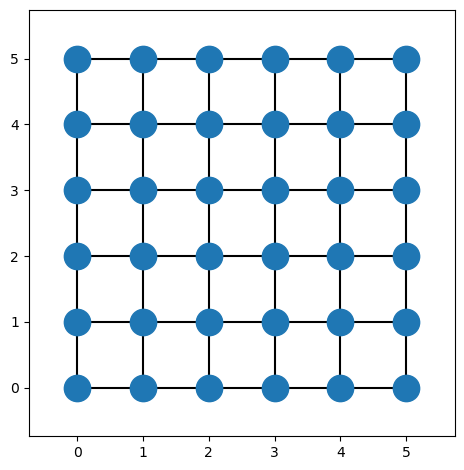

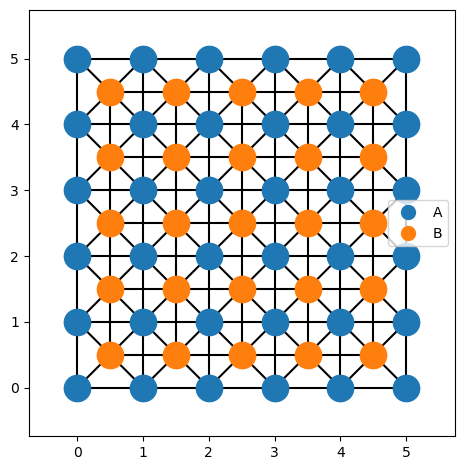

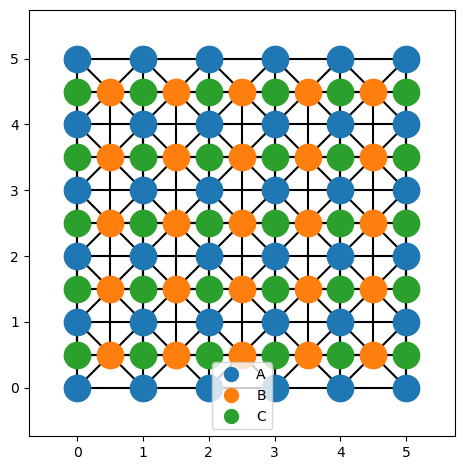

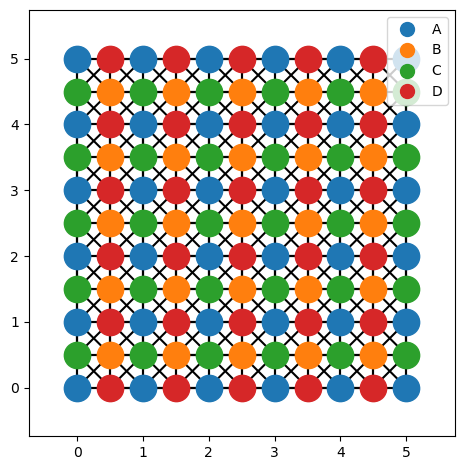

In [42]:
latt_1_atom = lp.Lattice(np.eye(2))  # Creamos un reticulo de 2 dimensiones (base ortonormal) le añadiremos 1 solo atomo
latt_2_atom = lp.Lattice(np.eye(2))  # mismo reticulo pero añadiremos 2 átomos
latt_3_atom = lp.Lattice(np.eye(2))  # mismo retículo pero añadiremos 3 atomos
latt_4_atom = lp.Lattice(np.eye(2))  # mismo retículo pero añadiremos 4 atomos

latt_1_atom.add_atom([1,  1], "A")  # Añadimos un átamo en el punto [1,1] en el reticulo que solo tendra 1 atomo.

latt_2_atom.add_atom([1,  1], "A") 
latt_2_atom.add_atom([1.5,  1.5], "B") # Añadimos dos átomos en los puntos [1,1] y [1.5,1.5] en el retículo que tendrá dos átomos

latt_3_atom.add_atom([1,  1], "A") 
latt_3_atom.add_atom([1.5,  1.5], "B")
latt_3_atom.add_atom([1,  1.5], "C") # Añadimos tres átomos en los puntos [1,1], [1.5,1.5] y [1,1.5] en el retículo que tendrá tres átomos

latt_4_atom.add_atom([1,  1], "A") 
latt_4_atom.add_atom([1.5,  1.5], "B")
latt_4_atom.add_atom([1,  1.5], "C") 
latt_4_atom.add_atom([0.5,  0], "D") # Añadimos cuatro átomos en los puntos [1,1], [1.5,1.5], [1,1.5] y [1,0.5] en el retículo que tendrá tres átomos

# Añadimos conexiones al primer vecino más cercano en todos los retículos.
latt_1_atom.add_connections(1)
latt_2_atom.add_connections(1)
latt_3_atom.add_connections(1)
latt_4_atom.add_connections(1)


#Construimos la red con un tamaño finito de todos los retículos, por ejemplo, 5x5
latt_1_atom.build((5,5))
latt_2_atom.build((5,5))
latt_3_atom.build((5,5))
latt_4_atom.build((5,5))


# Procesamos todos los retículos y los graficamos.
latt_1_atom.analyze()
latt_2_atom.analyze()
latt_3_atom.analyze()
latt_4_atom.analyze()
latt_1_atom.plot()
latt_2_atom.plot()
latt_3_atom.plot()
latt_4_atom.plot()
plt.show()

Como podemos observar, añadir un **átomo** en un punto del retículo se traduce en que, desde ese punto, se formarán las combinaciones lineales con los vectores base. Por lo tanto, un retículo 2D con dos átomos en posiciones diferentes no es más que la **suma de dos retículos 2D con un solo átomo**, cada uno ubicado en una posición distinta.

A continuación veremos que, **superponiendo dos retículos equivalentes** pero con **átomos distintos** obtenemos **los mismos puntos** que si crearamos un **reticulo** con ambos átomos.


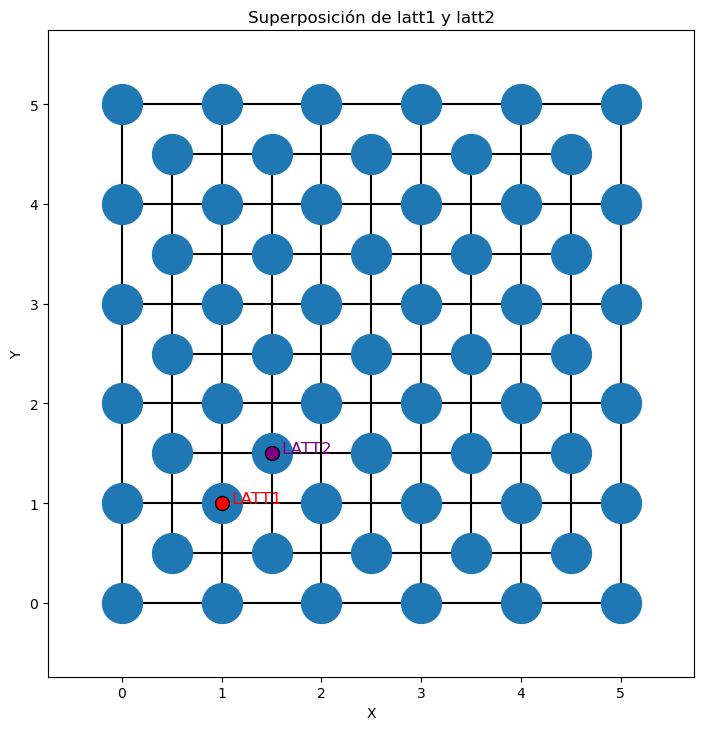

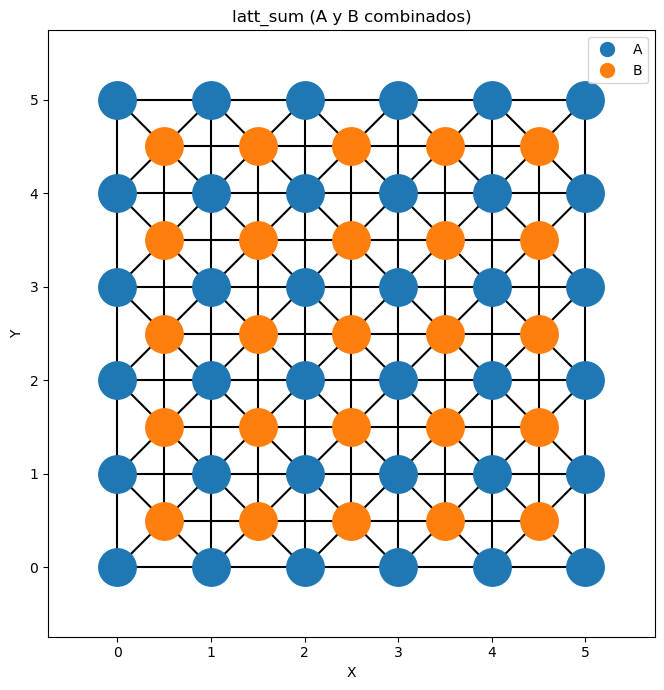

In [79]:
# 1. Crear los retículos con la base ortonormal 2D
latt1 = lp.Lattice(np.eye(2))  # Retículo 1
latt2 = lp.Lattice(np.eye(2))  # Retículo 2
latt_sum = lp.Lattice(np.eye(2))  # Retículo para la suma de latt1 y latt2

# 2. Añadir átomos a los retículos
latt1.add_atom([1, 1], "A")  # Átomo "A" en el punto [1, 1]
latt2.add_atom([1.5, 1.5], "B")  # Átomo "B" en el punto [1.5, 1.5]
latt_sum.add_atom([1, 1], "A")  # Átomo "A" de latt1
latt_sum.add_atom([1.5, 1.5], "B")  # Átomo "B" de latt2

# 3. Añadir conexiones al primer vecino más cercano
latt1.add_connections(1)
latt2.add_connections(1)
latt_sum.add_connections(1)

# 4. Construir la red con un tamaño finito 5
latt1.build((5, 5))
latt2.build((5, 5))
latt_sum.build((5, 5))

# 5. Procesar los retículos
latt1.analyze()
latt2.analyze()
latt_sum.analyze()

# 6. Crear una figura para superponer latt1 y latt2 en el mismo gráfico
fig, ax = plt.subplots(figsize=(7, 7))

# Graficamos latt1
latt1.plot(ax=ax, show=False)
ax.scatter([1], [1], color='red', s=100, edgecolors='black')  # Añadimos un señalizador en el átomo A relativo a LATT1
ax.text(1.1, 1, "LATT1", color='red', fontsize=12)  # Texto "LATT1" al lado del punto señalizador

# Graficamos latt2 (con puntos morados)
latt2.plot(ax=ax, show=False)
ax.scatter([1.5], [1.5], color='purple', s=100, edgecolors='black')   # Añadimos un señalizador en el átomo B relativo a LATT2
ax.text(1.6, 1.5, "LATT2", color='purple', fontsize=12)  # Texto "LATT2" al lado del punto señalizador

# Título y ajustes
ax.set_title("Superposición de latt1 y latt2")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# 7. Crear una figura aparte para latt_sum
fig2, ax2 = plt.subplots(figsize=(7, 7))

# Graficamos latt_sum
latt_sum.plot(ax=ax2, show=False)
ax2.set_title("latt_sum (A y B combinados)")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

# Mostrar ambas figuras
plt.tight_layout()
plt.show()


Nótese que la segunda figura relativa al **retículo suma** tiene conexiones adicionales entre los dos átomos y sus combinaciones lineales, pues así es como trata **lattpy** los **retículos con varios átomos**. Es facilmente deducible que con grandes dimensiones o límites, **añadir más átomos** tiene **implicaciones notables en el rendimiento**.

### 3.2 Generar Conexiones

AÑADIR CONEXIONES:

Finalmente, las conexiones de los átomos con sus vecinos deben configurarse. LattPy conecta 
automáticamente los vecinos de los sitios hasta un nivel especificado de distancias entre vecinos, 
es decir, primeros vecinos, segundos vecinos, y así sucesivamente. La distancia máxima entre vecinos 
puede configurarse de manera independiente para cada par de átomos.
Por ejemplo, si se asume una red cubica con dos átomos A y B en la celda unitaria,
las conexiones entre los átomos A pueden configurarse hasta los segundos vecinos, 
mientras que las conexiones entre los átomos A y B pueden limitarse únicamente a los primeros vecinos.

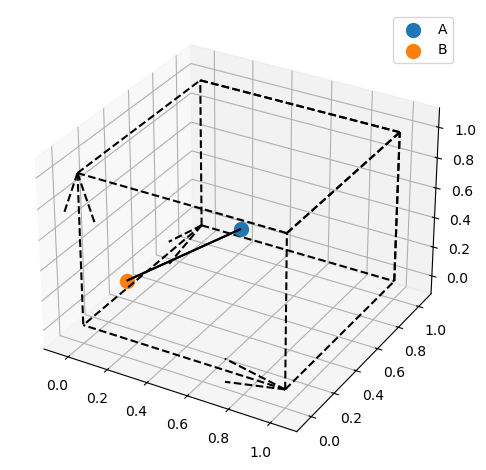

In [8]:
latt = lp.Lattice.sc(a=1)
latt.add_atom([0.50, 0.50, 0.50], "A")
latt.add_atom([0.1, 0.2, 0.2], "B")
#EN ESTE CASO A Y B SOLO SE CONECTARAN A 1 VECINO MAS CERCANO, EN ESTE CASO SON PARA A: B Y PARA B: A
latt.add_connection("A", "B", 1)
latt.analyze()
latt.plot_cell()
plt.show()

Si añadieramos un nuevo punto C más cercano del punto A que el punto B, obtendriamos la siguiente representacion

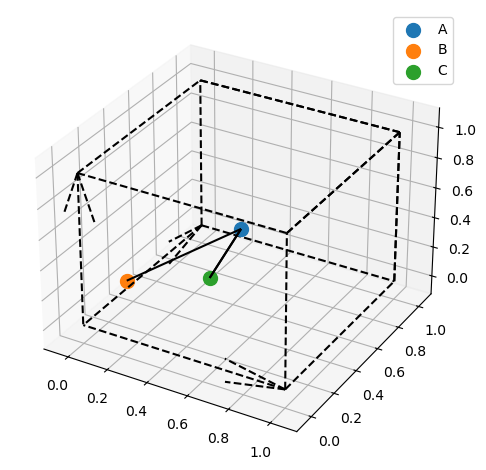

In [9]:
latt = lp.Lattice.sc(a=1)
latt.add_atom([0.50, 0.50, 0.50], "A")
latt.add_atom([0.1, 0.2, 0.2], "B")
latt.add_atom([0.4, 0.4 ,0.2], "C")

latt.add_connection("A", "B", 1)
latt.add_connection("A", "C", 1)
latt.analyze()
latt.plot_cell()
plt.show()

A continuacion veremos como la conexión se establece en la periodicidad, pues el punto más cercano no es aquel que se encuentra en el mismo periodo, sino en distino. En este caso, el punto A es más cercano al punto B periodico que al propio punto B, por eso establece la conexión con el primero.

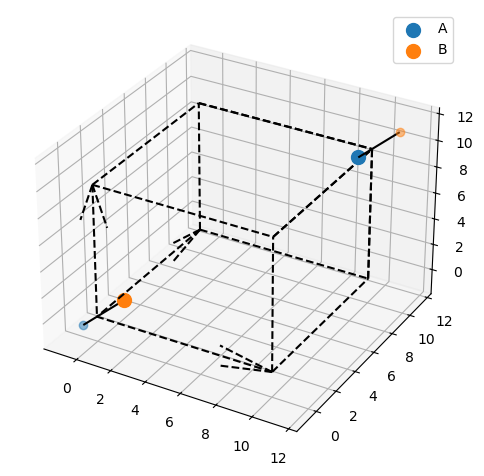

In [10]:
latt = lp.Lattice.sc(a=10)
latt.add_atom([9.50, 9.50, 9.50], "A")
latt.add_atom([1, 1, 1], "B")
latt.add_connection("A", "B", 1)
latt.analyze()
latt.plot_cell()
plt.show()

A continuación vemos un caso particular en el que colocamos un único punto en las coordenadas (0, 0, 0). En este caso el punto buscaría conexiónarme consigo mismo.
Al tocar el parámetro de la función add_connections($X$) vemos como busca conectarse con los $X$ puntos más cercanos. Con $1$ busca su periodico más cercano, con $2$ busca sus $2$ periodicos más cerncaos mostrando siempre todas las posibilidades.

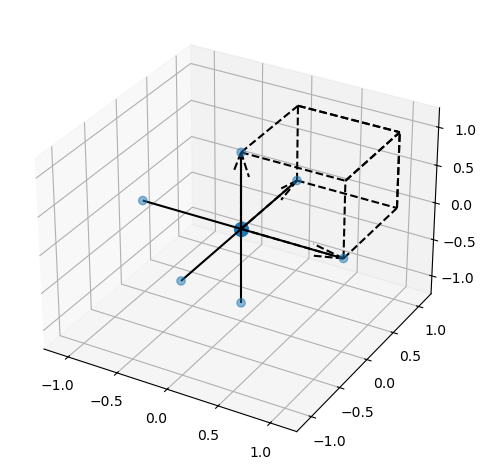

In [11]:
latt = lp.Lattice.sc()
latt.add_atom()

latt.add_connections(1)
latt.plot_cell()
plt.show()

En el siguiente ejemplo definimos un retículo cuadrado 2D con una base identidad y agregamos un átomo en la celda unitaria y conexiones de primer vecino. <br>
Construimos un retículo finito de tamaño 5x5, obtenemos los vecinos del primer sitio y mostramos sus posiciones. Finalmente, graficamos la celda unitaria.



El átomo en el índice 0 tiene conexiones con los siguientes índices:
[6 1]
Las posiciones de los vecinos son:
[array([1., 0.]), array([0., 1.])]


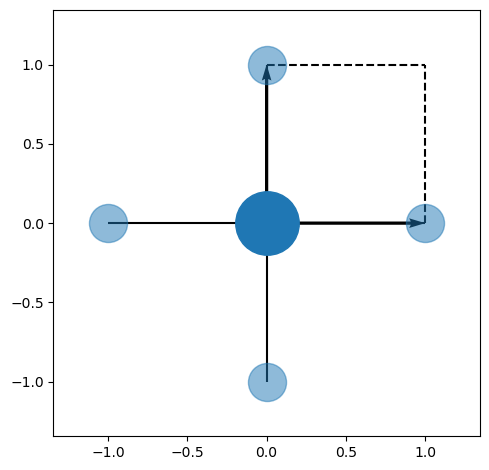

In [13]:
latt = lp.Lattice(np.eye(2))

#Agregamos un átomo en la celda unitaria
latt.add_atom()

#Agregamos conexiones de primer vecino
latt.add_connections(1)

#Construimos la red con un tamaño finito, por ejemplo, 5x5
latt.build((5,5))

#Seleccionamos el índice de un sitio específico (por ejemplo, el primero)
site_index = 0  # Puedes elegir otro índice dentro del rango del sistema construido

#Obtenemos los vecinos (conexiones) del sitio seleccionado
neighbors = latt.neighbors(site_index)

#Mostramos los resultados
print(f"El átomo en el índice {site_index} tiene conexiones con los siguientes índices:")
print(neighbors)

#Mostramos también las posiciones de los vecinos
positions = [latt.position(neighbor) for neighbor in neighbors]
print("Las posiciones de los vecinos son:")
print(positions)
latt.plot_cell()
plt.show()